In [27]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Preprocess data

In [29]:
# --- PATH CONFIGURATION ---
DATA_DIR = Path('../data')
OUTPUT_FILE = DATA_DIR / 'final_data.csv'

# Check if data directory exists
if not DATA_DIR.exists():
    print(f"ERROR: Directory {DATA_DIR.resolve()} does not exist!")
    
# --- MAIN LOGIC ---
# Check if the output file already exists
if OUTPUT_FILE.exists():
    print(f"File {OUTPUT_FILE} already exists. Skipping data generation.")
    
    # Optional: load the ready file to ensure the 'merged' variable is available
    merged = pd.read_csv(OUTPUT_FILE)
    print("Data loaded from existing file.")

else:
    print(f"File {OUTPUT_FILE} does not exist. Starting processing...")

    # --- 1. LOADING DATA ---
    # Setpoint data (PC -> Inv)
    data = pd.read_csv(DATA_DIR / 'setpoints.csv')
    data.rename(columns={'value': 'setpoint_fr', 'value2':'setpoint_rl', 'value3' : 'setpoint_rr'}, inplace=True)

    # Electrical data
    data2 = pd.read_csv(DATA_DIR / 'fsp_endu_current.csv')
    data2.rename(columns={'value': 'current', 'value2':'voltage'}, inplace=True)

    # Helper function for wheel data
    def load_wheel_data(filename, col_name):
        df = pd.read_csv(DATA_DIR / filename).drop(columns=['topic', 'timestamp'])
        df.rename(columns={'value': col_name}, inplace=True)
        df[col_name] = abs(df[col_name])
        return df

    data_fr = load_wheel_data('front_right_data.csv', 'speed_fr')
    data_rl = load_wheel_data('rear_left_data.csv', 'speed_rl')
    data_rr = load_wheel_data('rear_right_data.csv', 'speed_rr')

    # --- 2. MERGING AND SYNCHRONIZATION ---
    merged_wheels = pd.merge_asof(data_fr.sort_values('elapsed time'), 
                                  data_rl.sort_values('elapsed time'), 
                                  on='elapsed time', direction='nearest', tolerance=0.1)
    merged_wheels = pd.merge_asof(merged_wheels, 
                                  data_rr.sort_values('elapsed time'), 
                                  on='elapsed time', direction='nearest', tolerance=0.1)
    merged_wheels.interpolate(method='linear', inplace=True)

    # Merge everything
    merged = pd.merge_asof(data.sort_values('elapsed time'), 
                           data2.sort_values('elapsed time'), 
                           on='elapsed time', direction='nearest', tolerance=0.1)
    merged = pd.merge_asof(merged, merged_wheels, on='elapsed time', direction='nearest', tolerance=0.1)

    # --- 3. CLEANING AND FEATURE ENGINEERING ---
    merged['power'] = merged['voltage'] * merged['current']
    merged.drop(columns=['elapsed time', 'voltage', 'current'], inplace=True)
    merged.dropna(inplace=True)
    merged = merged[merged['power'] >= 0]

    # --- 4. SAVING RESULTS ---
    merged.to_csv(OUTPUT_FILE, index=False)
# 1. Wybór cech i celu
# Używamy 'merged' z poprzedniego etapu (lub wczytujemy plik jeśli trzeba)
if 'merged' not in locals():
    merged = pd.read_csv('final_data.csv')

features = ['setpoint_fr', 'setpoint_rl', 'setpoint_rr', 
            'speed_fr', 'speed_rl', 'speed_rr']
target = 'power'

# 2. Stworzenie macierzy X i wektora y
X = merged[features]
y = merged[target]

# 3. Podział na zbiór treningowy (80%) i testowy (20%)
# random_state=42 gwarantuje, że za każdym razem podział będzie identyczny
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Weryfikacja rozmiarów (dla pewności)
print(f"Liczba próbek treningowych: {X_train.shape[0]}")
print(f"Liczba próbek testowych:    {X_test.shape[0]}")   
print(f"Success! New file saved to: {OUTPUT_FILE}")

File ../data/final_data.csv already exists. Skipping data generation.
Data loaded from existing file.
Liczba próbek treningowych: 41441
Liczba próbek testowych:    10361
Success! New file saved to: ../data/final_data.csv


# Regresja Liniowa

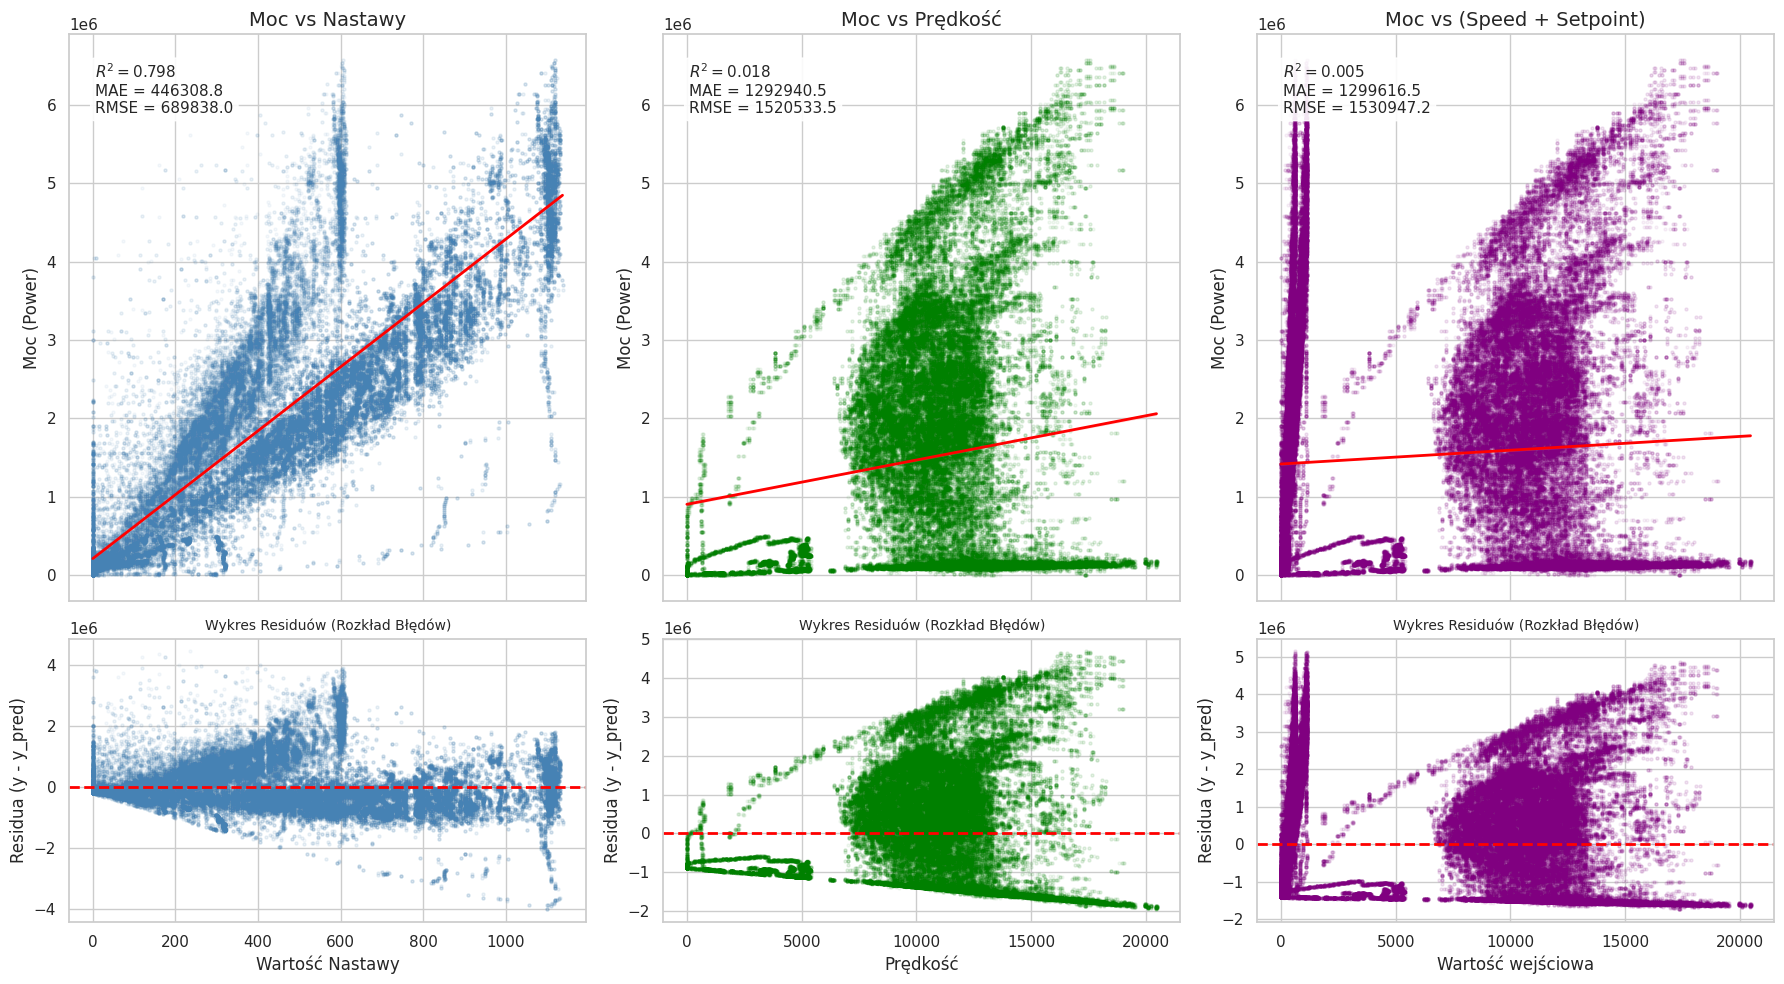

In [34]:
# Upewniamy się, że styl jest ustawiony
sns.set_theme(style="whitegrid")

# Sprawdzenie czy dane są wczytane
if 'merged' not in locals():
    try:
        merged = pd.read_csv('final_data.csv')
    except:
        print("Brak danych. Uruchom najpierw blok wczytywania danych.")

# --- 1. PRZYGOTOWANIE DANYCH AGREGOWANYCH ---
X_setpoints = pd.concat([merged['setpoint_fr'], merged['setpoint_rl'], merged['setpoint_rr']], ignore_index=True)
Y_setpoints = pd.concat([merged['power'], merged['power'], merged['power']], ignore_index=True)

X_speeds = pd.concat([merged['speed_fr'], merged['speed_rl'], merged['speed_rr']], ignore_index=True)
Y_speeds = pd.concat([merged['power'], merged['power'], merged['power']], ignore_index=True)

X_all = pd.concat([X_setpoints, X_speeds], ignore_index=True)
Y_all = pd.concat([Y_setpoints, Y_speeds], ignore_index=True)


# --- 2. FUNKCJE POMOCNICZE ---

def plot_regression(x_data, y_data, ax, color, title, xlabel):
    """Rysuje górny wykres: Regresja Liniowa z metrykami"""
    X_reshaped = x_data.values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X_reshaped, y_data)
    y_pred = model.predict(X_reshaped)
    
    # Metryki
    r2 = r2_score(y_data, y_pred)
    mae = mean_absolute_error(y_data, y_pred)
    rmse = np.sqrt(mean_squared_error(y_data, y_pred))
    
    # Wykres
    sns.regplot(x=x_data, y=y_data, ax=ax,
                scatter_kws={'alpha': 0.05, 'color': color, 's': 5},
                line_kws={'color': 'red', 'linewidth': 2})
    
    stats_text = (f"$R^2 = {r2:.3f}$\n"
                  f"MAE = {mae:.1f}\n"
                  f"RMSE = {rmse:.1f}")
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('') # Usuwamy opis osi X dla górnego wykresu (żeby nie dublować)
    ax.set_ylabel('Moc (Power)')
    ax.tick_params(labelbottom=False) # Ukrywamy etykiety osi X na górnym wykresie

def plot_residuals(x_data, y_data, ax, color, xlabel):
    """Rysuje dolny wykres: Residua (Błędy)"""
    X_reshaped = x_data.values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X_reshaped, y_data)
    y_pred = model.predict(X_reshaped)
    
    # Obliczenie residuów (Błąd = Rzeczywistość - Model)
    residuals = y_data - y_pred
    
    # Rysowanie
    ax.scatter(x_data, residuals, alpha=0.05, s=5, color=color)
    ax.axhline(0, color='red', linestyle='--', lw=2) # Linia zerowa (brak błędu)
    
    ax.set_title('Wykres Residuów (Rozkład Błędów)', fontsize=10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Residua (y - y_pred)')

# --- 3. RYSOWANIE CAŁOŚCI (SIATKA 2x3) ---
# Zwiększamy wysokość figsize, bo mamy teraz 2 rzędy
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex='col', gridspec_kw={'height_ratios': [2, 1]})

# --- KOLUMNA 1: Nastawy ---
plot_regression(X_setpoints, Y_setpoints, axes[0, 0], 'steelblue', 
                'Moc vs Nastawy', 'Wartość Nastawy')
plot_residuals(X_setpoints, Y_setpoints, axes[1, 0], 'steelblue', 'Wartość Nastawy')

# --- KOLUMNA 2: Prędkości ---
plot_regression(X_speeds, Y_speeds, axes[0, 1], 'green', 
                'Moc vs Prędkość', 'Prędkość')
plot_residuals(X_speeds, Y_speeds, axes[1, 1], 'green', 'Prędkość')

# --- KOLUMNA 3: Wszystko razem ---
plot_regression(X_all, Y_all, axes[0, 2], 'purple', 
                'Moc vs (Speed + Setpoint)', 'Wartość wejściowa')
plot_residuals(X_all, Y_all, axes[1, 2], 'purple', 'Wartość wejściowa')

plt.tight_layout()
plt.show()

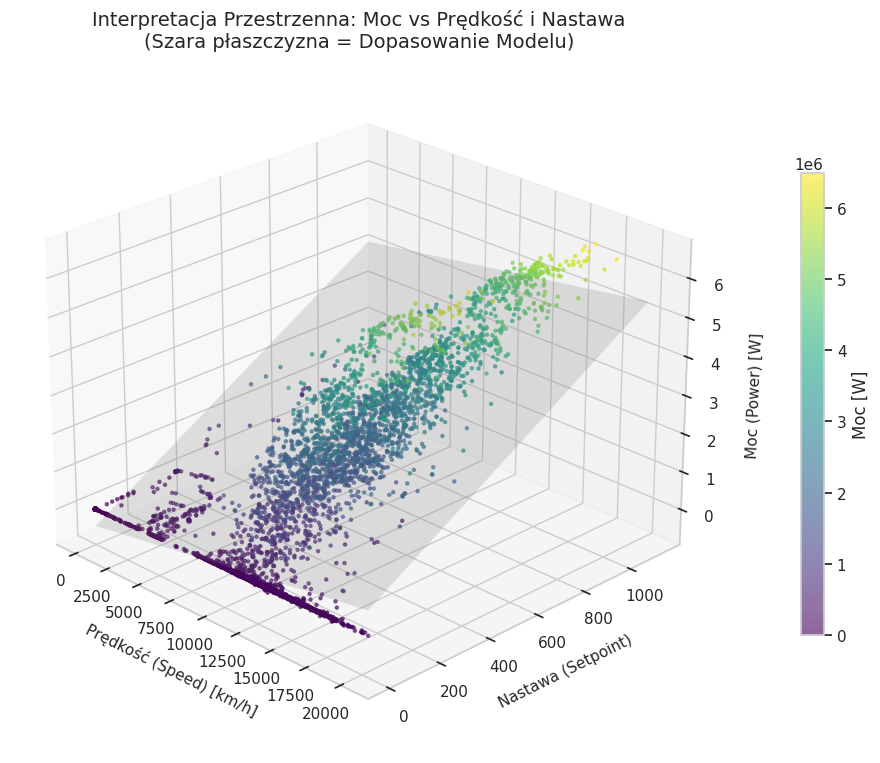

In [ ]:
# 1. WCZYTANIE DANYCH
if 'merged' not in locals():
    try:
        merged = pd.read_csv('final_data.csv')
    except FileNotFoundError:
        print("Błąd: Brak pliku danych. Uruchom najpierw blok przetwarzania.")

# 2. PRZYGOTOWANIE DANYCH (Stackowanie 3 kół w jedną listę)
# Tworzymy trójki: (Speed, Setpoint, Power) dla każdego pomiaru ze wszystkich kół
X_speed_all = pd.concat([merged['speed_fr'], merged['speed_rl'], merged['speed_rr']], ignore_index=True)
Y_setpoint_all = pd.concat([merged['setpoint_fr'], merged['setpoint_rl'], merged['setpoint_rr']], ignore_index=True)
Z_power_all = pd.concat([merged['power'], merged['power'], merged['power']], ignore_index=True)

# 3. SAMPLING (Ograniczenie liczby punktów dla czytelności wykresu)
# Wykresy 3D stają się nieczytelne przy >10k punktów. Losujemy 5000 próbek.
if len(X_speed_all) > 5000:
    sample_idx = np.random.choice(X_speed_all.index, 5000, replace=False)
else:
    sample_idx = X_speed_all.index

xs = X_speed_all.iloc[sample_idx] # Oś X: Prędkość
ys = Y_setpoint_all.iloc[sample_idx] # Oś Y: Nastawa
zs = Z_power_all.iloc[sample_idx] # Oś Z: Moc

# 4. KONFIGURACJA WYKRESU 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Rysujemy punkty danych (Scatter plot)
img = ax.scatter(xs, ys, zs, c=zs, cmap='viridis', s=5, alpha=0.6, label='Pomiary')

# 5. DODANIE POWIERZCHNI TEORETYCZNEJ (Model Fizyczny)
v_mesh = np.linspace(xs.min(), xs.max(), 30)
s_mesh = np.linspace(ys.min(), ys.max(), 30)
V, S = np.meshgrid(v_mesh, s_mesh)


temp_model = make_pipeline(LinearRegression())
temp_model.fit(np.column_stack((xs, ys)), zs)

# Przewidujemy moc dla każdego punktu siatki
Z_surf = temp_model.predict(np.column_stack((V.ravel(), S.ravel()))).reshape(V.shape)

# Rysujemy powierzchnię 
ax.plot_surface(V, S, Z_surf, color='gray', alpha=0.2, rstride=1, cstride=1, edgecolor='none')

# Opisy osi i tytuł
ax.set_xlabel('\nPrędkość (Speed) [km/h]', fontsize=11)
ax.set_ylabel('\nNastawa (Setpoint)', fontsize=11)
ax.set_zlabel('\nMoc (Power) [W]', fontsize=11)
ax.set_title('Interpretacja Przestrzenna: Moc vs Prędkość i Nastawa\n(Szara płaszczyzna = Dopasowanie Modelu)', fontsize=14)

# Dodanie paska kolorów (legenda mocy)
cbar = fig.colorbar(img, ax=ax, pad=0.1, shrink=0.6)
cbar.set_label('Moc [W]')

# Ustawienie kąta widzenia (możesz eksperymentować z tymi wartościami)
ax.view_init(elev=25, azim=-45)

plt.show()

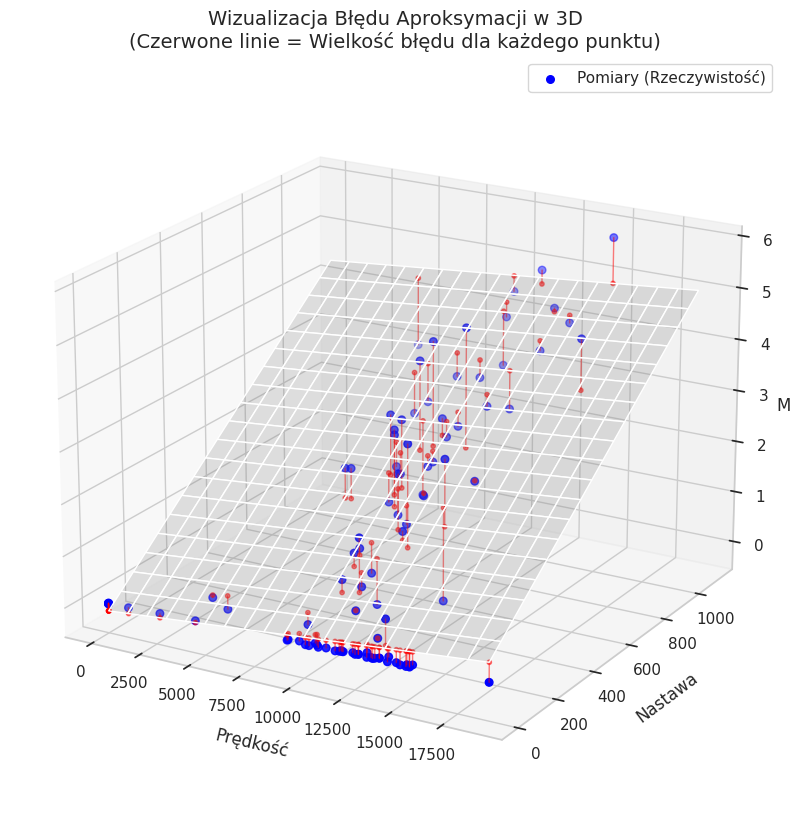

In [ ]:
# 1. PRZYGOTOWANIE DANYCH
if 'merged' not in locals():
    try:
        merged = pd.read_csv('final_data.csv')
    except:
        print("Brak danych. Uruchom najpierw blok wczytywania danych.")

X_speed = pd.concat([merged['speed_fr'], merged['speed_rl'], merged['speed_rr']], ignore_index=True)
Y_setpoint = pd.concat([merged['setpoint_fr'], merged['setpoint_rl'], merged['setpoint_rr']], ignore_index=True)
Z_power = pd.concat([merged['power'], merged['power'], merged['power']], ignore_index=True)

sample_idx = np.random.choice(X_speed.index, 100, replace=False)
xs = X_speed.iloc[sample_idx].values
ys = Y_setpoint.iloc[sample_idx].values
zs = Z_power.iloc[sample_idx].values

# 2. TRENOWANIE MODELU 
model = make_pipeline(LinearRegression()) 
model.fit(np.column_stack((xs, ys)), zs)

zs_pred = model.predict(np.column_stack((xs, ys)))

# 3. RYSOWANIE 3D Z BŁĘDAMI
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# A. Rzeczywiste punkty (Niebieskie)
ax.scatter(xs, ys, zs, c='blue', s=30, label='Pomiary (Rzeczywistość)')

# B. Punkty na modelu (Czerwone - rzuty na płaszczyznę)
ax.scatter(xs, ys, zs_pred, c='red', s=10, alpha=0.5)

# C. Płaszczyzna modelu (Szara siatka)
v_mesh = np.linspace(xs.min(), xs.max(), 20)
s_mesh = np.linspace(ys.min(), ys.max(), 20)
V, S = np.meshgrid(v_mesh, s_mesh)
Z_surf = model.predict(np.column_stack((V.ravel(), S.ravel()))).reshape(V.shape)
ax.plot_surface(V, S, Z_surf, color='gray', alpha=0.2, rstride=1, cstride=1)

# D. LINIE BŁĘDÓW
for i in range(len(xs)):
    ax.plot([xs[i], xs[i]], [ys[i], ys[i]], [zs[i], zs_pred[i]], 
            color='red', alpha=0.5, linewidth=1)

ax.set_xlabel('\nPrędkość', fontsize=12)
ax.set_ylabel('\nNastawa', fontsize=12)
ax.set_zlabel('\nMoc', fontsize=12)
ax.set_title('Wizualizacja Błędu Aproksymacji w 3D\n(Czerwone linie = Wielkość błędu dla każdego punktu)', fontsize=14)
ax.legend()

# Ustawienie widoku
ax.view_init(elev=20, azim=-60)

plt.show()

# Regresja wielomianowa


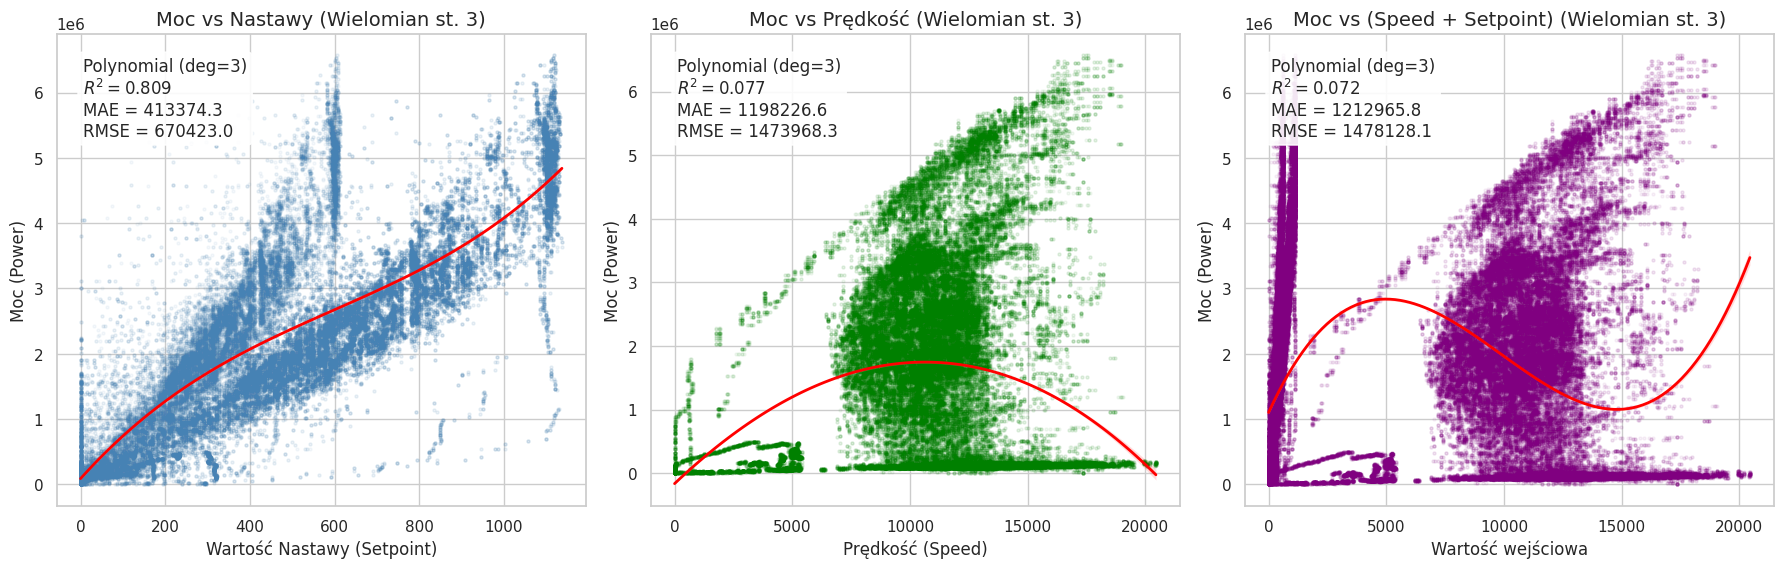

In [ ]:
# Upewniamy się, że styl jest ustawiony
sns.set_theme(style="whitegrid")

# Sprawdzenie czy dane są wczytane
if 'merged' not in locals():
    try:
        merged = pd.read_csv('final_data.csv')
    except:
        print("Brak danych. Uruchom najpierw blok wczytywania danych.")

# --- 1. PRZYGOTOWANIE DANYCH AGREGOWANYCH 
X_setpoints = pd.concat([merged['setpoint_fr'], merged['setpoint_rl'], merged['setpoint_rr']], ignore_index=True)
Y_setpoints = pd.concat([merged['power'], merged['power'], merged['power']], ignore_index=True)

X_speeds = pd.concat([merged['speed_fr'], merged['speed_rl'], merged['speed_rr']], ignore_index=True)
Y_speeds = pd.concat([merged['power'], merged['power'], merged['power']], ignore_index=True)

X_all = pd.concat([X_setpoints, X_speeds], ignore_index=True)
Y_all = pd.concat([Y_setpoints, Y_speeds], ignore_index=True)

# --- 2. FUNKCJA POMOCNICZA DLA WIELOMIANÓW 
def plot_poly3_with_metrics(x_data, y_data, ax, color, title, xlabel):
    # 1. Budowa i trenowanie modelu wielomianowego (stopień 3)
    X_reshaped = x_data.values.reshape(-1, 1)
    
    # Pipeline: Tworzy cechy wielomianowe 
    degree = 3
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
    model.fit(X_reshaped, y_data)
    y_pred = model.predict(X_reshaped)
    
    # 2. Obliczenie metryk
    r2 = r2_score(y_data, y_pred)
    mae = mean_absolute_error(y_data, y_pred)
    rmse = np.sqrt(mean_squared_error(y_data, y_pred))
    
    # 3. Rysowanie wykresu z dopasowaniem wielomianowym (order=3)
    sns.regplot(x=x_data, y=y_data, ax=ax, order=degree,
                scatter_kws={'alpha': 0.05, 'color': color, 's': 5},
                line_kws={'color': 'red', 'linewidth': 2})
    
    # 4. Dodanie ramki z wynikami
    stats_text = (f"Polynomial (deg={degree})\n"
                  f"$R^2 = {r2:.3f}$\n"
                  f"MAE = {mae:.1f}\n"
                  f"RMSE = {rmse:.1f}")
    
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Moc (Power)')


# --- 3. RYSOWANIE WYKRESÓW ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Wykres 1: Moc vs Nastawy (Wielomian 3 stopnia)
plot_poly3_with_metrics(X_setpoints, Y_setpoints, axes[0], 'steelblue', 
                       'Moc vs Nastawy (Wielomian st. 3)', 'Wartość Nastawy (Setpoint)')

# Wykres 2: Moc vs Prędkości (Wielomian 3 stopnia)
plot_poly3_with_metrics(X_speeds, Y_speeds, axes[1], 'green', 
                       'Moc vs Prędkość (Wielomian st. 3)', 'Prędkość (Speed)')

# Wykres 3: Moc vs (Speed + Setpoint) (Wielomian 3 stopnia)
plot_poly3_with_metrics(X_all, Y_all, axes[2], 'purple', 
                       'Moc vs (Speed + Setpoint) (Wielomian st. 3)', 'Wartość wejściowa')

plt.tight_layout()
plt.show()

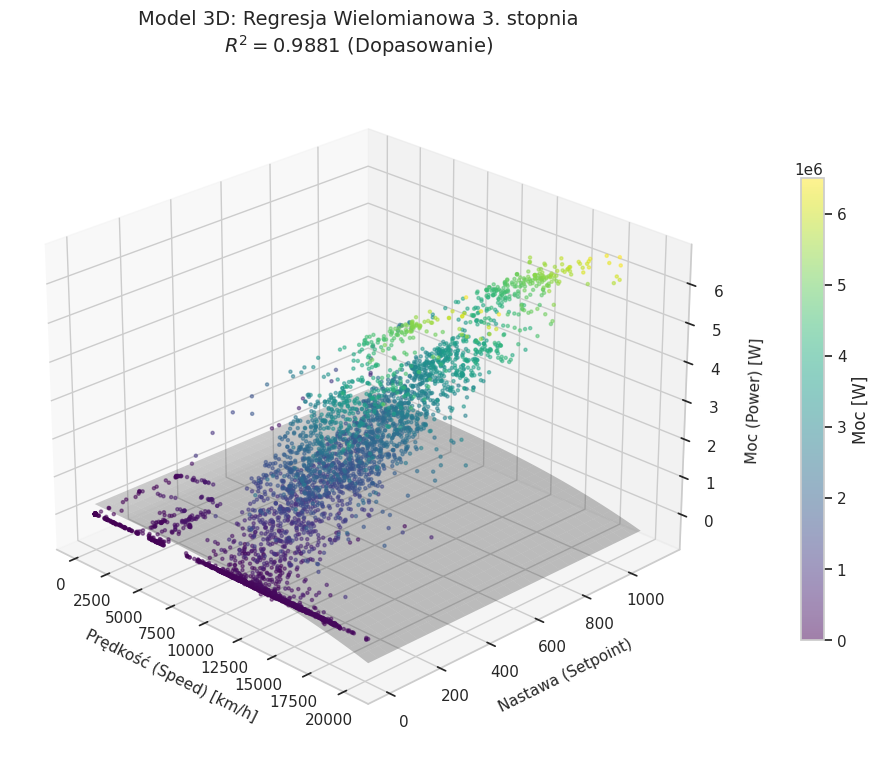

In [ ]:
# 1. WCZYTANIE DANYCH
if 'merged' not in locals():
    try:
        merged = pd.read_csv('final_data.csv')
    except FileNotFoundError:
        print("Brak danych. Uruchom najpierw blok przetwarzania.")

# 2. PRZYGOTOWANIE DANYCH 
X_speed_all = pd.concat([merged['speed_fr'], merged['speed_rl'], merged['speed_rr']], ignore_index=True)
Y_setpoint_all = pd.concat([merged['setpoint_fr'], merged['setpoint_rl'], merged['setpoint_rr']], ignore_index=True)
Z_power_all = pd.concat([merged['power'], merged['power'], merged['power']], ignore_index=True)

# Tworzymy macierz cech (X) i wektor celu (y) dla modelu
# Model musi widzieć pary (Prędkość, Nastawa), aby nauczyć się powierzchni
X_train_3d = pd.DataFrame({'speed': X_speed_all, 'setpoint': Y_setpoints})
y_train_3d = Z_power_all

# 3. TRENING MODELU (Wielomian 3. stopnia)
model_poly3 = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
model_poly3.fit(X_train_3d, y_train_3d)
score_poly3 = model_poly3.score(X_train_3d, y_train_3d)

# 4. SAMPLING
if len(X_speed_all) > 5000:
    sample_idx = np.random.choice(X_speed_all.index, 5000, replace=False)
else:
    sample_idx = X_speed_all.index

xs = X_speed_all.iloc[sample_idx]
ys = Y_setpoint_all.iloc[sample_idx]
zs = Z_power_all.iloc[sample_idx]

# 5. KONFIGURACJA WYKRESU 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Rysujemy punkty danych (Pomiary)
img = ax.scatter(xs, ys, zs, c=zs, cmap='viridis', s=5, alpha=0.5, label='Pomiary')

# 6. RYSOWANIE POWIERZCHNI MODELU
v_mesh = np.linspace(xs.min(), xs.max(), 30)
s_mesh = np.linspace(ys.min(), ys.max(), 30)
V, S = np.meshgrid(v_mesh, s_mesh)

# Przewidujemy moc dla każdego punktu siatki używając naszego modelu 3. stopnia
grid_input = pd.DataFrame({'speed': V.ravel(), 'setpoint': S.ravel()})
Z_surf = model_poly3.predict(grid_input).reshape(V.shape)

# Rysujemy powierzchnię
ax.plot_surface(V, S, Z_surf, color='gray', alpha=0.3, rstride=1, cstride=1, edgecolor='none')

# Opisy
ax.set_xlabel('\nPrędkość (Speed) [km/h]', fontsize=11)
ax.set_ylabel('\nNastawa (Setpoint)', fontsize=11)
ax.set_zlabel('\nMoc (Power) [W]', fontsize=11)
ax.set_title(f'Model 3D: Regresja Wielomianowa 3. stopnia\n$R^2 = {score_poly3:.4f}$ (Dopasowanie)', fontsize=14)

# Pasek kolorów
cbar = fig.colorbar(img, ax=ax, pad=0.1, shrink=0.6)
cbar.set_label('Moc [W]')

# Kąt widzenia
ax.view_init(elev=25, azim=-45)

plt.show()

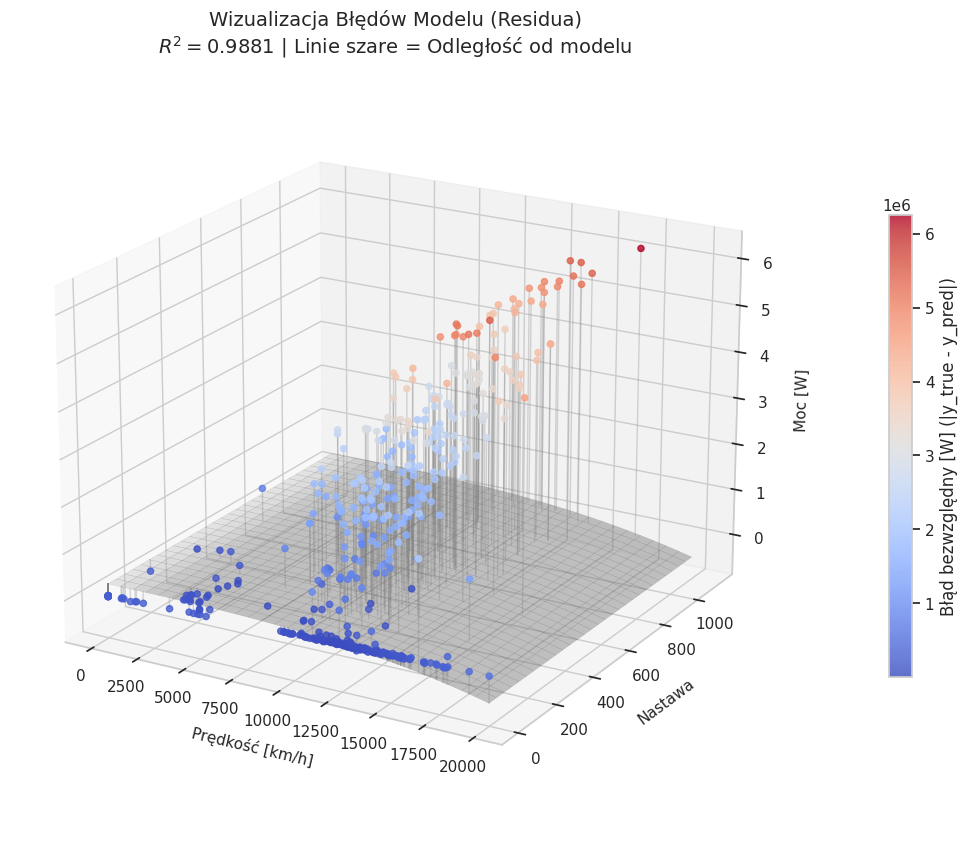

In [ ]:
# 4. SAMPLING (Do wyświetlenia punktów)
sample_size = 500  
if len(X_speed_all) > sample_size:
    sample_idx = np.random.choice(X_speed_all.index, sample_size, replace=False)
else:
    sample_idx = X_speed_all.index

xs = X_speed_all.iloc[sample_idx]
ys = Y_setpoint_all.iloc[sample_idx]
zs = Z_power_all.iloc[sample_idx]

# --- NOWOŚĆ: 4a. OBLICZANIE BŁĘDÓW DLA PRÓBKI ---
sample_input = pd.DataFrame({'speed': xs, 'setpoint': ys})
zs_pred = model_poly3.predict(sample_input)

errors = zs - zs_pred
abs_errors = np.abs(errors) 

# 5. KONFIGURACJA WYKRESU 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Rysujemy punkty danych
img = ax.scatter(xs, ys, zs, c=abs_errors, cmap='coolwarm', s=20, alpha=0.8, label='Pomiary (Kolor=Błąd)')


for x, y, z_true, z_pred in zip(xs, ys, zs, zs_pred):
    color = 'red' if z_true > z_pred else 'blue' # Czerwona linia jeśli punkt nad modelem
    ax.plot([x, x], [y, y], [z_true, z_pred], color='gray', alpha=0.3, linewidth=1)

# 6. RYSOWANIE POWIERZCHNI MODELU 
v_mesh = np.linspace(xs.min(), xs.max(), 30)
s_mesh = np.linspace(ys.min(), ys.max(), 30)
V, S = np.meshgrid(v_mesh, s_mesh)

grid_input = pd.DataFrame({'speed': V.ravel(), 'setpoint': S.ravel()})
Z_surf = model_poly3.predict(grid_input).reshape(V.shape)


ax.plot_surface(V, S, Z_surf, color='white', alpha=0.4, rstride=1, cstride=1, edgecolor='k', linewidth=0.1)

# Opisy i Tytuł
ax.set_xlabel('\nPrędkość [km/h]', fontsize=11)
ax.set_ylabel('\nNastawa', fontsize=11)
ax.set_zlabel('\nMoc [W]', fontsize=11)
ax.set_title(f'Wizualizacja Błędów Modelu (Residua)\n$R^2 = {score_poly3:.4f}$ | Linie szare = Odległość od modelu', fontsize=14)

# Pasek kolorów (Legenda błędów)
cbar = fig.colorbar(img, ax=ax, pad=0.1, shrink=0.6)
cbar.set_label('Błąd bezwzględny [W] (|y_true - y_pred|)')

ax.view_init(elev=20, azim=-60)
plt.show()